# ECE239AS Project

#### Load the dataset

In [1]:
from useful.utils import *
import numpy as np
import h5py
import torch
import matplotlib.pyplot as plt
import glob
import torchvision.transforms
import random
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

train_loader, test_loader,val_loader = loader()(path='./project_datasets/A01T_slice.mat',
                                                batch_size= 20,
                                                num_test = 50,
                                                num_validation = 50)

/Users/shuangyu/anaconda3/envs/pytorch/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


X_shape (288, 22, 1000)
y_shape (1, 1000)
nan exists on row 56,and be deleted
Train data shape:  (187, 22, 1000)
Train labels shape:  (187,)
test data shape:  (50, 22, 1000)
test labels shape:  (50,)
Validation data shape:  (50, 22, 1000)
Validation labels shape:  (50,)


In [72]:
criteria = F.cross_entropy

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target).long()
        optimizer.zero_grad()
        output = model(data)
        loss = criteria(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 5 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
    

def test(test_loader=val_loader, mode = 'val'):
    # train mode to get the train accuracy 
    # val mode to get the validation accuracy
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target).long()
        output = model(data)
        test_loss += criteria(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    if mode == 'train':
        print('train loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        

    else:
        print('validation loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    
    return [test_loss,correct / len(test_loader.dataset)]

## Model 2 
conv align time axis

Train Epoch: 0 [0/187 (0%)]	Loss: 1.376669
Train Epoch: 0 [100/187 (50%)]	Loss: 1.451936
train loss: 1.3603, Accuracy: 58/187 (31%)
validation loss: 1.3989, Accuracy: 14/50 (28%)

Train Epoch: 1 [0/187 (0%)]	Loss: 1.328487
Train Epoch: 1 [100/187 (50%)]	Loss: 1.393923
train loss: 1.3450, Accuracy: 62/187 (33%)
validation loss: 1.4229, Accuracy: 12/50 (24%)

Train Epoch: 2 [0/187 (0%)]	Loss: 1.338921
Train Epoch: 2 [100/187 (50%)]	Loss: 1.359910
train loss: 1.3370, Accuracy: 60/187 (32%)
validation loss: 1.4363, Accuracy: 11/50 (22%)

Train Epoch: 3 [0/187 (0%)]	Loss: 1.390062
Train Epoch: 3 [100/187 (50%)]	Loss: 1.315432
train loss: 1.3286, Accuracy: 61/187 (33%)
validation loss: 1.4400, Accuracy: 8/50 (16%)

Train Epoch: 4 [0/187 (0%)]	Loss: 1.357743
Train Epoch: 4 [100/187 (50%)]	Loss: 1.390465
train loss: 1.3205, Accuracy: 63/187 (34%)
validation loss: 1.4284, Accuracy: 10/50 (20%)

Train Epoch: 5 [0/187 (0%)]	Loss: 1.389253
Train Epoch: 5 [100/187 (50%)]	Loss: 1.420919
train loss: 

Text(0.5,1,'accuracy')

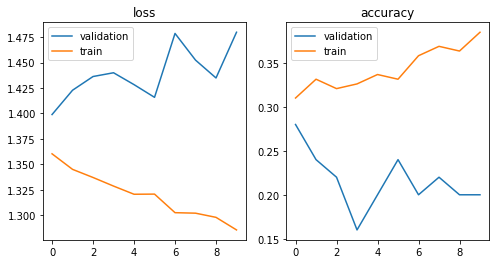

In [17]:
import torch.autograd as autograd
import matplotlib.pyplot as plt


class RNN_LSTM(nn.Module):
    def __init__(self):
        super(RNN_LSTM, self).__init__()
        
        self.feature = nn.Sequential(
                        nn.Conv2d(1, 1, kernel_size=(1, 10), stride=1, padding=0),
        )
        
        self.lstm = nn.LSTM(22, 64, 1,
                            batch_first=True,dropout = 0.9)
        
        self.fc = nn.Sequential(
                    nn.Linear(64, 4),
                    
        )
        
    def forward(self, x):
        # prepare feature map for rnn
        x = self.feature(x)
        
        # prare the dimension for rnn
        B,C,H,W = x.size()
        x = x.view(B,H,W).permute(0, 2, 1)
    
        # Forward propagate RNN
        out, _ = self.lstm(x)
        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out
    

    
model = RNN_LSTM()

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, betas=(0.9,0.999), eps=1e-08, weight_decay=0.005)
stats = {}
stats['train'] = []
stats['val']  = []

epoches = range(10)
for epoch in epoches:
    train(epoch)
    stats['train'].append(test(train_loader,mode = 'train'))
    stats['val'].append(test(test_loader,mode = 'val'))

# draw a figure for this layer
stats['val']  = np.array(stats['val'])
stats['train'] = np.array(stats['train'])

fig, ax = plt.subplots(1, 2,figsize = (8,4))
ax[0].plot(epoches,stats['val'][:,0],epoches,stats['train'][:,0])

ax[0].legend(['validation','train'])
ax[0].set_title('loss')

ax[1].plot(epoches,stats['val'][:,1],epoches,stats['train'][:,1])

ax[1].legend(['validation','train'])
ax[1].set_title('accuracy')

## model 3
conv on axis = 0

In [25]:
# Flatten function
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size()
        return x.view(N, -1)

# Permute function
class Permute(nn.Module):
    def forward(self, x):
        return x.permute(0, 2, 1, 3)

Train Epoch: 0 [0/187 (0%)]	Loss: 1.371860
Train Epoch: 0 [100/187 (50%)]	Loss: 1.377512
train loss: 1.3837, Accuracy: 51/187 (27%)
validation loss: 1.3880, Accuracy: 11/50 (22%)

Train Epoch: 1 [0/187 (0%)]	Loss: 1.375610
Train Epoch: 1 [100/187 (50%)]	Loss: 1.348342
train loss: 1.3772, Accuracy: 52/187 (28%)
validation loss: 1.3896, Accuracy: 10/50 (20%)

Train Epoch: 2 [0/187 (0%)]	Loss: 1.343943
Train Epoch: 2 [100/187 (50%)]	Loss: 1.404783
train loss: 1.3706, Accuracy: 59/187 (32%)
validation loss: 1.3925, Accuracy: 9/50 (18%)

Train Epoch: 3 [0/187 (0%)]	Loss: 1.376456
Train Epoch: 3 [100/187 (50%)]	Loss: 1.388654
train loss: 1.3639, Accuracy: 63/187 (34%)
validation loss: 1.3959, Accuracy: 11/50 (22%)

Train Epoch: 4 [0/187 (0%)]	Loss: 1.359520
Train Epoch: 4 [100/187 (50%)]	Loss: 1.336679
train loss: 1.3591, Accuracy: 66/187 (35%)
validation loss: 1.3976, Accuracy: 12/50 (24%)

Train Epoch: 5 [0/187 (0%)]	Loss: 1.303347
Train Epoch: 5 [100/187 (50%)]	Loss: 1.356217
train loss: 

Text(0.5,1,'accuracy')

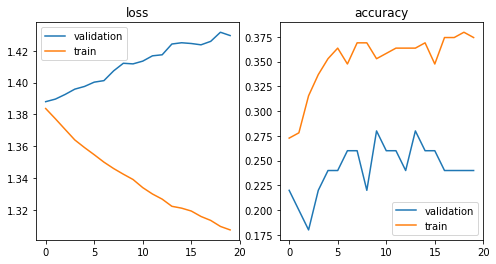

In [27]:
import torch.autograd as autograd
import matplotlib.pyplot as plt

# BN_momentum = 0.2
# ELU_alpha = 0.9
# drop_out = 0.4

class RNN_LSTM(nn.Module):
    def __init__(self):
        super(RNN_LSTM, self).__init__()
        
        self.feature = nn.Sequential(
            
            nn.Conv2d(1, 25, kernel_size=(22, 1), stride=1, padding=0),
            nn.ELU(alpha=0.9, inplace=True),
            nn.BatchNorm2d(num_features=25, eps=1e-05, momentum=0.1, affine=True),
            # 25, 1, 1000
            Permute()
            # 1, 25, 1000
        )
        
        self.lstm = nn.LSTM(25, 64, 1,
                            batch_first=True,dropout = 0.9)
        
        self.fc = nn.Sequential(
                    nn.Linear(64, 4),
                    
        )
        
    def forward(self, x):
        # prepare feature map for rnn
        x = self.feature(x)
        
        # prare the dimension for rnn
        B,C,H,W = x.size()
        x = x.view(B,H,W).permute(0, 2, 1)
    
        # Forward propagate RNN
        out, _ = self.lstm(x)
        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out
    

    
model = RNN_LSTM()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007, betas=(0.9,0.999), eps=1e-08, weight_decay=0.01)
stats = {}
stats['train'] = []
stats['val']  = []

epoches = range(20)
for epoch in epoches:
    train(epoch)
    stats['train'].append(test(train_loader,mode = 'train'))
    stats['val'].append(test(test_loader,mode = 'val'))

# draw a figure for this layer
stats['val']  = np.array(stats['val'])
stats['train'] = np.array(stats['train'])

fig, ax = plt.subplots(1, 2,figsize = (8,4))
ax[0].plot(epoches,stats['val'][:,0],epoches,stats['train'][:,0])

ax[0].legend(['validation','train'])
ax[0].set_title('loss')

ax[1].plot(epoches,stats['val'][:,1],epoches,stats['train'][:,1])

ax[1].legend(['validation','train'])
ax[1].set_title('accuracy')

## model 4
cnn align both axis

Train Epoch: 0 [0/187 (0%)]	Loss: 1.422451
Train Epoch: 0 [100/187 (50%)]	Loss: 1.391787
train loss: 1.3614, Accuracy: 61/187 (33%)
validation loss: 1.4225, Accuracy: 10/50 (20%)

Train Epoch: 1 [0/187 (0%)]	Loss: 1.319998
Train Epoch: 1 [100/187 (50%)]	Loss: 1.375846
train loss: 1.3499, Accuracy: 65/187 (35%)
validation loss: 1.4386, Accuracy: 7/50 (14%)

Train Epoch: 2 [0/187 (0%)]	Loss: 1.312040
Train Epoch: 2 [100/187 (50%)]	Loss: 1.295795
train loss: 1.3378, Accuracy: 68/187 (36%)
validation loss: 1.4318, Accuracy: 10/50 (20%)

Train Epoch: 3 [0/187 (0%)]	Loss: 1.392581
Train Epoch: 3 [100/187 (50%)]	Loss: 1.342877
train loss: 1.3167, Accuracy: 78/187 (42%)
validation loss: 1.4447, Accuracy: 9/50 (18%)

Train Epoch: 4 [0/187 (0%)]	Loss: 1.377528
Train Epoch: 4 [100/187 (50%)]	Loss: 1.251240
train loss: 1.2993, Accuracy: 80/187 (43%)
validation loss: 1.4402, Accuracy: 8/50 (16%)

Train Epoch: 5 [0/187 (0%)]	Loss: 1.369344
Train Epoch: 5 [100/187 (50%)]	Loss: 1.270587
train loss: 1.

Train Epoch: 45 [100/187 (50%)]	Loss: 0.463413
train loss: 0.2056, Accuracy: 177/187 (95%)
validation loss: 3.2792, Accuracy: 12/50 (24%)

Train Epoch: 46 [0/187 (0%)]	Loss: 0.123665
Train Epoch: 46 [100/187 (50%)]	Loss: 0.116096
train loss: 0.1358, Accuracy: 181/187 (97%)
validation loss: 3.1571, Accuracy: 14/50 (28%)

Train Epoch: 47 [0/187 (0%)]	Loss: 0.065328
Train Epoch: 47 [100/187 (50%)]	Loss: 0.105383
train loss: 0.1147, Accuracy: 186/187 (99%)
validation loss: 3.5049, Accuracy: 11/50 (22%)

Train Epoch: 48 [0/187 (0%)]	Loss: 0.114108
Train Epoch: 48 [100/187 (50%)]	Loss: 0.123057
train loss: 0.1873, Accuracy: 180/187 (96%)
validation loss: 3.6328, Accuracy: 12/50 (24%)

Train Epoch: 49 [0/187 (0%)]	Loss: 0.181008
Train Epoch: 49 [100/187 (50%)]	Loss: 0.081133
train loss: 0.3253, Accuracy: 164/187 (88%)
validation loss: 3.7302, Accuracy: 9/50 (18%)



Text(0.5,1,'accuracy')

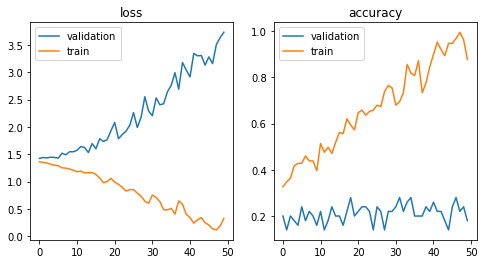

In [24]:
import torch.autograd as autograd
import matplotlib.pyplot as plt

# BN_momentum = 0.2
# ELU_alpha = 0.9
# drop_out = 0.4

class RNN_LSTM(nn.Module):
    def __init__(self):
        super(RNN_LSTM, self).__init__()
        
        self.feature = nn.Sequential(
            nn.Conv2d(1, 25, kernel_size=(1, 10), stride=1, padding=0),
            nn.BatchNorm2d(num_features=25, eps=1e-05, momentum=0.1, affine=True),
            # 25, 22, 996
    
            nn.Conv2d(25, 25, kernel_size=(22, 1), stride=1, padding=0),
            nn.ELU(alpha=0.9, inplace=True),
            nn.BatchNorm2d(num_features=25, eps=1e-05, momentum=0.1, affine=True),
            # 25, 1, 996
    
            Permute()
            # 1, 25, 996
        )
        
        self.lstm = nn.LSTM(25, 64, 1,
                            batch_first=True,dropout = 0.9)
        
        self.fc = nn.Sequential(
                    nn.Linear(64, 4),
                    
        )
        
    def forward(self, x):
        # prepare feature map for rnn
        x = self.feature(x)
        
        # prare the dimension for rnn
        B,C,H,W = x.size()
        x = x.view(B,H,W).permute(0, 2, 1)
    
        # Forward propagate RNN
        out, _ = self.lstm(x)
        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out
    

    
model = RNN_LSTM()

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, betas=(0.9,0.999), eps=1e-08, weight_decay=0.005)
stats = {}
stats['train'] = []
stats['val']  = []

epoches = range(50)
for epoch in epoches:
    train(epoch)
    stats['train'].append(test(train_loader,mode = 'train'))
    stats['val'].append(test(test_loader,mode = 'val'))

# draw a figure for this layer
stats['val']  = np.array(stats['val'])
stats['train'] = np.array(stats['train'])

fig, ax = plt.subplots(1, 2,figsize = (8,4))
ax[0].plot(epoches,stats['val'][:,0],epoches,stats['train'][:,0])

ax[0].legend(['validation','train'])
ax[0].set_title('loss')

ax[1].plot(epoches,stats['val'][:,1],epoches,stats['train'][:,1])

ax[1].legend(['validation','train'])
ax[1].set_title('accuracy')

## model 5

Our best cnn model + lstm

(20, 22, 1000)


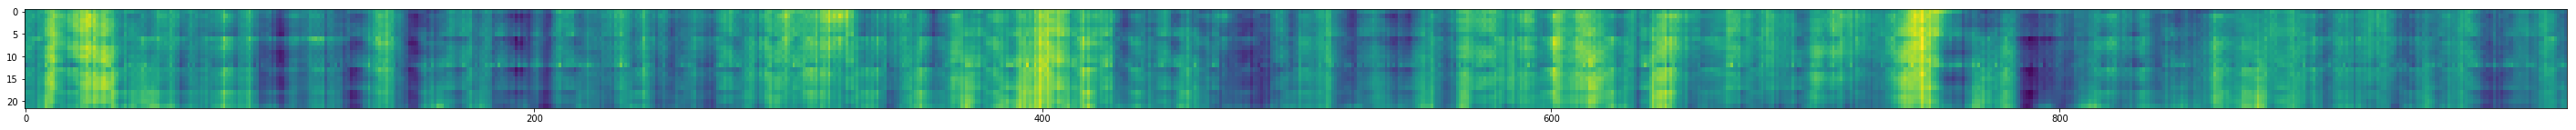

In [63]:
import matplotlib.pyplot as plt

for batch_idx, (data, target) in enumerate(train_loader):
        data = data.numpy().reshape((20,22,1000))
        print(data.shape)
        break
fig, ax = plt.subplots(figsize=(50, 2))
ax.imshow(data[0],aspect='auto')


Train Epoch: 0 [0/187 (0%)]	Loss: 1.398740
Train Epoch: 0 [100/187 (50%)]	Loss: 1.380584
train loss: 1.3809, Accuracy: 49/187 (26%)
validation loss: 1.3954, Accuracy: 12/50 (24%)

Train Epoch: 1 [0/187 (0%)]	Loss: 1.389155
Train Epoch: 1 [100/187 (50%)]	Loss: 1.363158
train loss: 1.3710, Accuracy: 69/187 (37%)
validation loss: 1.3987, Accuracy: 13/50 (26%)

Train Epoch: 2 [0/187 (0%)]	Loss: 1.348159
Train Epoch: 2 [100/187 (50%)]	Loss: 1.368678
train loss: 1.3677, Accuracy: 90/187 (48%)
validation loss: 1.3950, Accuracy: 9/50 (18%)

Train Epoch: 3 [0/187 (0%)]	Loss: 1.354182
Train Epoch: 3 [100/187 (50%)]	Loss: 1.350419
train loss: 1.3352, Accuracy: 91/187 (49%)
validation loss: 1.3844, Accuracy: 14/50 (28%)

Train Epoch: 4 [0/187 (0%)]	Loss: 1.344082
Train Epoch: 4 [100/187 (50%)]	Loss: 1.320234
train loss: 1.2984, Accuracy: 93/187 (50%)
validation loss: 1.3941, Accuracy: 10/50 (20%)

Train Epoch: 5 [0/187 (0%)]	Loss: 1.317359
Train Epoch: 5 [100/187 (50%)]	Loss: 1.247891
train loss: 

Text(0.5,1,'accuracy')

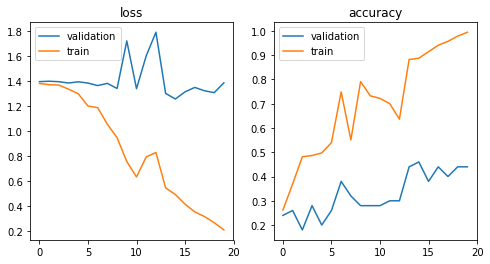

In [67]:
import torch.autograd as autograd
import matplotlib.pyplot as plt


class RNN_LSTM(nn.Module):
    def __init__(self):
        super(RNN_LSTM, self).__init__()
        
        self.feature = nn.Sequential(
            
                nn.Conv2d(1, 25, kernel_size=(1, 10), stride=1, padding=0),
                nn.BatchNorm2d(num_features=25, eps=1e-05, momentum=0.2, affine=True),
                # 25, 22, 991

                nn.Conv2d(25, 25, kernel_size=(2, 20), stride=1, padding=0),
                nn.ELU(alpha=0.9, inplace=True),
                nn.BatchNorm2d(num_features=25, eps=1e-05, momentum=0.2, affine=True),

                nn.Conv2d(25, 25, kernel_size=(21, 1), stride=1, padding=0),
                nn.ELU(alpha=0.9, inplace=True),
                nn.BatchNorm2d(num_features=25, eps=1e-05, momentum=0.2, affine=True),
                # 25, 1, 991

                Permute(),
                # 1, 25, 991

                nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3)),
                # 1, 25, 330

                nn.Conv2d(1, 50, kernel_size=(25, 10), stride=1, padding=0),
                nn.ELU(alpha=0.9, inplace=True),
                nn.BatchNorm2d(num_features=50, eps=1e-05, momentum=0.2, affine=True),
                # 50, 1, 321

                Permute(),
                # 1, 50, 323

                nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3)),
                # 1, 50, 107

                nn.Conv2d(1, 100, kernel_size=(50, 10), stride=1, padding=0),
                nn.ELU(alpha=0.9, inplace=True),
                nn.BatchNorm2d(num_features=100, eps=1e-05, momentum=0.2, affine=True),
                # 100, 1, 98

                Permute(),
                # 1, 100, 98

                nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3)),
                # 1, 100, 32

                nn.Conv2d(1, 200, kernel_size=(100, 10), stride=1, padding=0),
                nn.ELU(alpha=0.9, inplace=True),
                nn.BatchNorm2d(num_features=200, eps=1e-05, momentum=0.2, affine=True),
                # 200, 1, 23

                Permute(),
                # 1, 200, 23

                nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3)),
                # 1, 200, 7
            
                )
        
        self.lstm = nn.LSTM(7, 64, 1,
                            batch_first=True,dropout = 0.9)
        
        self.fc = nn.Sequential(
                    nn.Linear(64, 4),
                    
        )
        
    def forward(self, x):
        # prepare feature map for rnn
        x = self.feature(x)
        
        # prare the dimension for rnn
        B,C,H,W = x.size()
        x = x.view(B,H,W).permute(0, 1, 2)
    
        # Forward propagate RNN
        out, _ = self.lstm(x)
        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out
    

    
model = RNN_LSTM()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007, betas=(0.9,0.999), eps=1e-08, weight_decay=0.01)
stats = {}
stats['train'] = []
stats['val']  = []

epoches = range(20)
for epoch in epoches:
    train(epoch)
    stats['train'].append(test(train_loader,mode = 'train'))
    stats['val'].append(test(test_loader,mode = 'val'))

# draw a figure for this layer
stats['val']  = np.array(stats['val'])
stats['train'] = np.array(stats['train'])

fig, ax = plt.subplots(1, 2,figsize = (8,4))
ax[0].plot(epoches,stats['val'][:,0],epoches,stats['train'][:,0])

ax[0].legend(['validation','train'])
ax[0].set_title('loss')

ax[1].plot(epoches,stats['val'][:,1],epoches,stats['train'][:,1])

ax[1].legend(['validation','train'])
ax[1].set_title('accuracy')

In [71]:
test(train_loader,mode = 'test')

validation loss: 0.2091, Accuracy: 186/187 (99%)



[0.2090879716975166, 0.9946524064171123]

# CNN+RNN

In [5]:
import torch.autograd as autograd
import matplotlib.pyplot as plt

# Flatten function
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size()
        return x.view(N, -1)

# Permute function
class Permute(nn.Module):
    def forward(self, x):
        return x.permute(0, 2, 1, 3)

class RNN_LSTM(nn.Module):
    def __init__(self):
        super(RNN_LSTM, self).__init__()
        
        self.feature = nn.Sequential(
            
                nn.Conv2d(1, 25, kernel_size=(1, 10), stride=1, padding=0),
                nn.BatchNorm2d(num_features=25, eps=1e-05, momentum=0.2, affine=True),
                # 25, 22, 991

                nn.Conv2d(25, 25, kernel_size=(2, 20), stride=1, padding=0),
                nn.ELU(alpha=0.9, inplace=True),
                nn.BatchNorm2d(num_features=25, eps=1e-05, momentum=0.2, affine=True),

                nn.Conv2d(25, 25, kernel_size=(21, 1), stride=1, padding=0),
                nn.ELU(alpha=0.9, inplace=True),
                nn.BatchNorm2d(num_features=25, eps=1e-05, momentum=0.2, affine=True),
                # 25, 1, 991

                Permute(),
                # 1, 25, 991

                nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3)),
                # 1, 25, 330

                nn.Conv2d(1, 50, kernel_size=(25, 10), stride=1, padding=0),
                nn.ELU(alpha=0.9, inplace=True),
                nn.BatchNorm2d(num_features=50, eps=1e-05, momentum=0.2, affine=True),
                # 50, 1, 321

                Permute(),
                # 1, 50, 323

                nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3)),
                # 1, 50, 107

                nn.Conv2d(1, 100, kernel_size=(50, 10), stride=1, padding=0),
                nn.ELU(alpha=0.9, inplace=True),
                nn.BatchNorm2d(num_features=100, eps=1e-05, momentum=0.2, affine=True),
                # 100, 1, 98

                Permute(),
                # 1, 100, 98

                nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3)),
                # 1, 100, 32

                nn.Conv2d(1, 200, kernel_size=(100, 10), stride=1, padding=0),
                nn.ELU(alpha=0.9, inplace=True),
                nn.BatchNorm2d(num_features=200, eps=1e-05, momentum=0.2, affine=True),
                # 200, 1, 23

                Permute(),
                # 1, 200, 23

                nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3)),
                # 1, 200, 7
            
                )
        
        self.lstm = nn.LSTM(7, 64, 1,
                            batch_first=True,dropout = 0.9)
        
        self.fc = nn.Sequential(
                    nn.Linear(64, 4),
                    
        )
        
    def forward(self, x):
        # prepare feature map for rnn
        x = self.feature(x)
        
        # prare the dimension for rnn
        B,C,H,W = x.size()
        x = x.view(B,H,W).permute(0, 1, 2)
    
        # Forward propagate RNN
        out, _ = self.lstm(x)
        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out

### subject 1

In [6]:
train_loader, test_loader,val_loader = loader()(path='./project_datasets/A01T_slice.mat',
                                                batch_size= 20,
                                                num_test = 50,
                                                num_validation = 50)

#----------------------------------------#

model = RNN_LSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007, betas=(0.9,0.999), eps=1e-08, weight_decay=0.01)
stats = {}
stats['train'] = []
stats['val']  = []

epoches = range(20)
for epoch in epoches:
    train(epoch)
    stats['train'].append(test(train_loader,mode = 'train'))
    stats['val'].append(test(test_loader,mode = 'val'))

# draw a figure for this layer
stats['val']  = np.array(stats['val'])
stats['train'] = np.array(stats['train'])

fig, ax = plt.subplots(1, 2,figsize = (8,4))
ax[0].plot(epoches,stats['val'][:,0],epoches,stats['train'][:,0])

ax[0].legend(['validation','train'])
ax[0].set_title('loss')

ax[1].plot(epoches,stats['val'][:,1],epoches,stats['train'][:,1])

ax[1].legend(['validation','train'])
ax[1].set_title('accuracy')

X_shape (288, 22, 1000)
y_shape (1, 1000)
nan exists on row 56,and be deleted
Train data shape:  (187, 22, 1000)
Train labels shape:  (187,)
test data shape:  (50, 22, 1000)
test labels shape:  (50,)
Validation data shape:  (50, 22, 1000)
Validation labels shape:  (50,)


NameError: name 'train' is not defined